### Q. 각 날짜의 1시간 전의 기상상황을 가지고 1시간 후의 따릉이 대여수를 예측해보세요.
#### 대여량예측이니까 선형회귀

#### - 데이터 정규화(standscaler)를 한 경우입니다.
#### - optuna는 아직 적용하지 않았습니다.
#### - k-fold를 사용합니다
#### - 앙상블 랜덤포레스트 트리를 사용합니다

1. train.csv / test.csv
- id 고유 id
-hour 시간
- temperature 기온
- precipitation 비가 오지 않았으면 0, 비가 오면 1
- windspeed 풍속(평균)
- humidity 습도
- visibility 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
- ozone 오존
- pm10 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
- pm2.5 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
- count 시간에 따른 따릉이 대여 수


2.  submission.csv (제출 파일 형식)

In [144]:
import pandas as pd

### 1. 데이터 로딩 및 확인

In [145]:
train = pd.read_csv("train.csv")
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


In [146]:
train.tail()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
1454,2174,4,16.8,0.0,1.6,53.0,2000.0,0.031,37.0,27.0,21.0
1455,2175,3,10.8,0.0,3.8,45.0,2000.0,0.039,34.0,19.0,20.0
1456,2176,5,18.3,0.0,1.9,54.0,2000.0,0.009,30.0,21.0,22.0
1457,2178,21,20.7,0.0,3.7,37.0,1395.0,0.082,71.0,36.0,216.0
1458,2179,17,21.1,0.0,3.1,47.0,1973.0,0.046,38.0,17.0,170.0


In [147]:
type(train)

pandas.core.frame.DataFrame

### 2. 결측치 확인 및 전처리

In [148]:
train.isnull().sum()

id                          0
hour                        0
hour_bef_temperature        2
hour_bef_precipitation      2
hour_bef_windspeed          9
hour_bef_humidity           2
hour_bef_visibility         2
hour_bef_ozone             76
hour_bef_pm10              90
hour_bef_pm2.5            117
count                       0
dtype: int64

In [149]:
train[train['hour_bef_temperature'].isnull()] #행번호 : 934, 1035

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [150]:
train[train['hour_bef_windspeed'].isnull()] 

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
18,33,13,22.6,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0
244,381,1,14.1,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0
260,404,3,14.0,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0
376,570,0,14.3,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0
780,1196,20,16.5,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0
934,1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1035,1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1138,1717,12,21.4,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0
1229,1855,2,14.0,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0


### 2개씩 결측값이 있던던 것은 모든 행이 다 NA -> 없애버리기
- hour_bef_temperature 을 기준으로 2행 제거

In [152]:
train.dropna(subset=['hour_bef_temperature'], inplace = True)

In [153]:
train.shape

(1457, 11)

In [154]:
train.head()

,id,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
1,6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
2,7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
3,8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
4,9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


#### 9개, 117개 결측값 -> median사용해서 처리

In [155]:
train.fillna(train.median(numeric_only = True), inplace = True)

In [158]:
train.isnull().sum()

id                        0
hour                      0
hour_bef_temperature      0
hour_bef_precipitation    0
hour_bef_windspeed        0
hour_bef_humidity         0
hour_bef_visibility       0
hour_bef_ozone            0
hour_bef_pm10             0
hour_bef_pm2.5            0
count                     0
dtype: int64

In [157]:
train.shape

(1457, 11)

### 3. 무슨관계에 있을지 몰라 일단 pairplot그려봄

- 근데 따릉이 대여수와 관계있는걸 알고싶다고 했으니까, count(마지막줄) 주목!
- hour_bef_temperature, hour_bef_windspeed, hour_bef_ozone 와는 우상향관계
- hour_bef_humidity	우하향관계

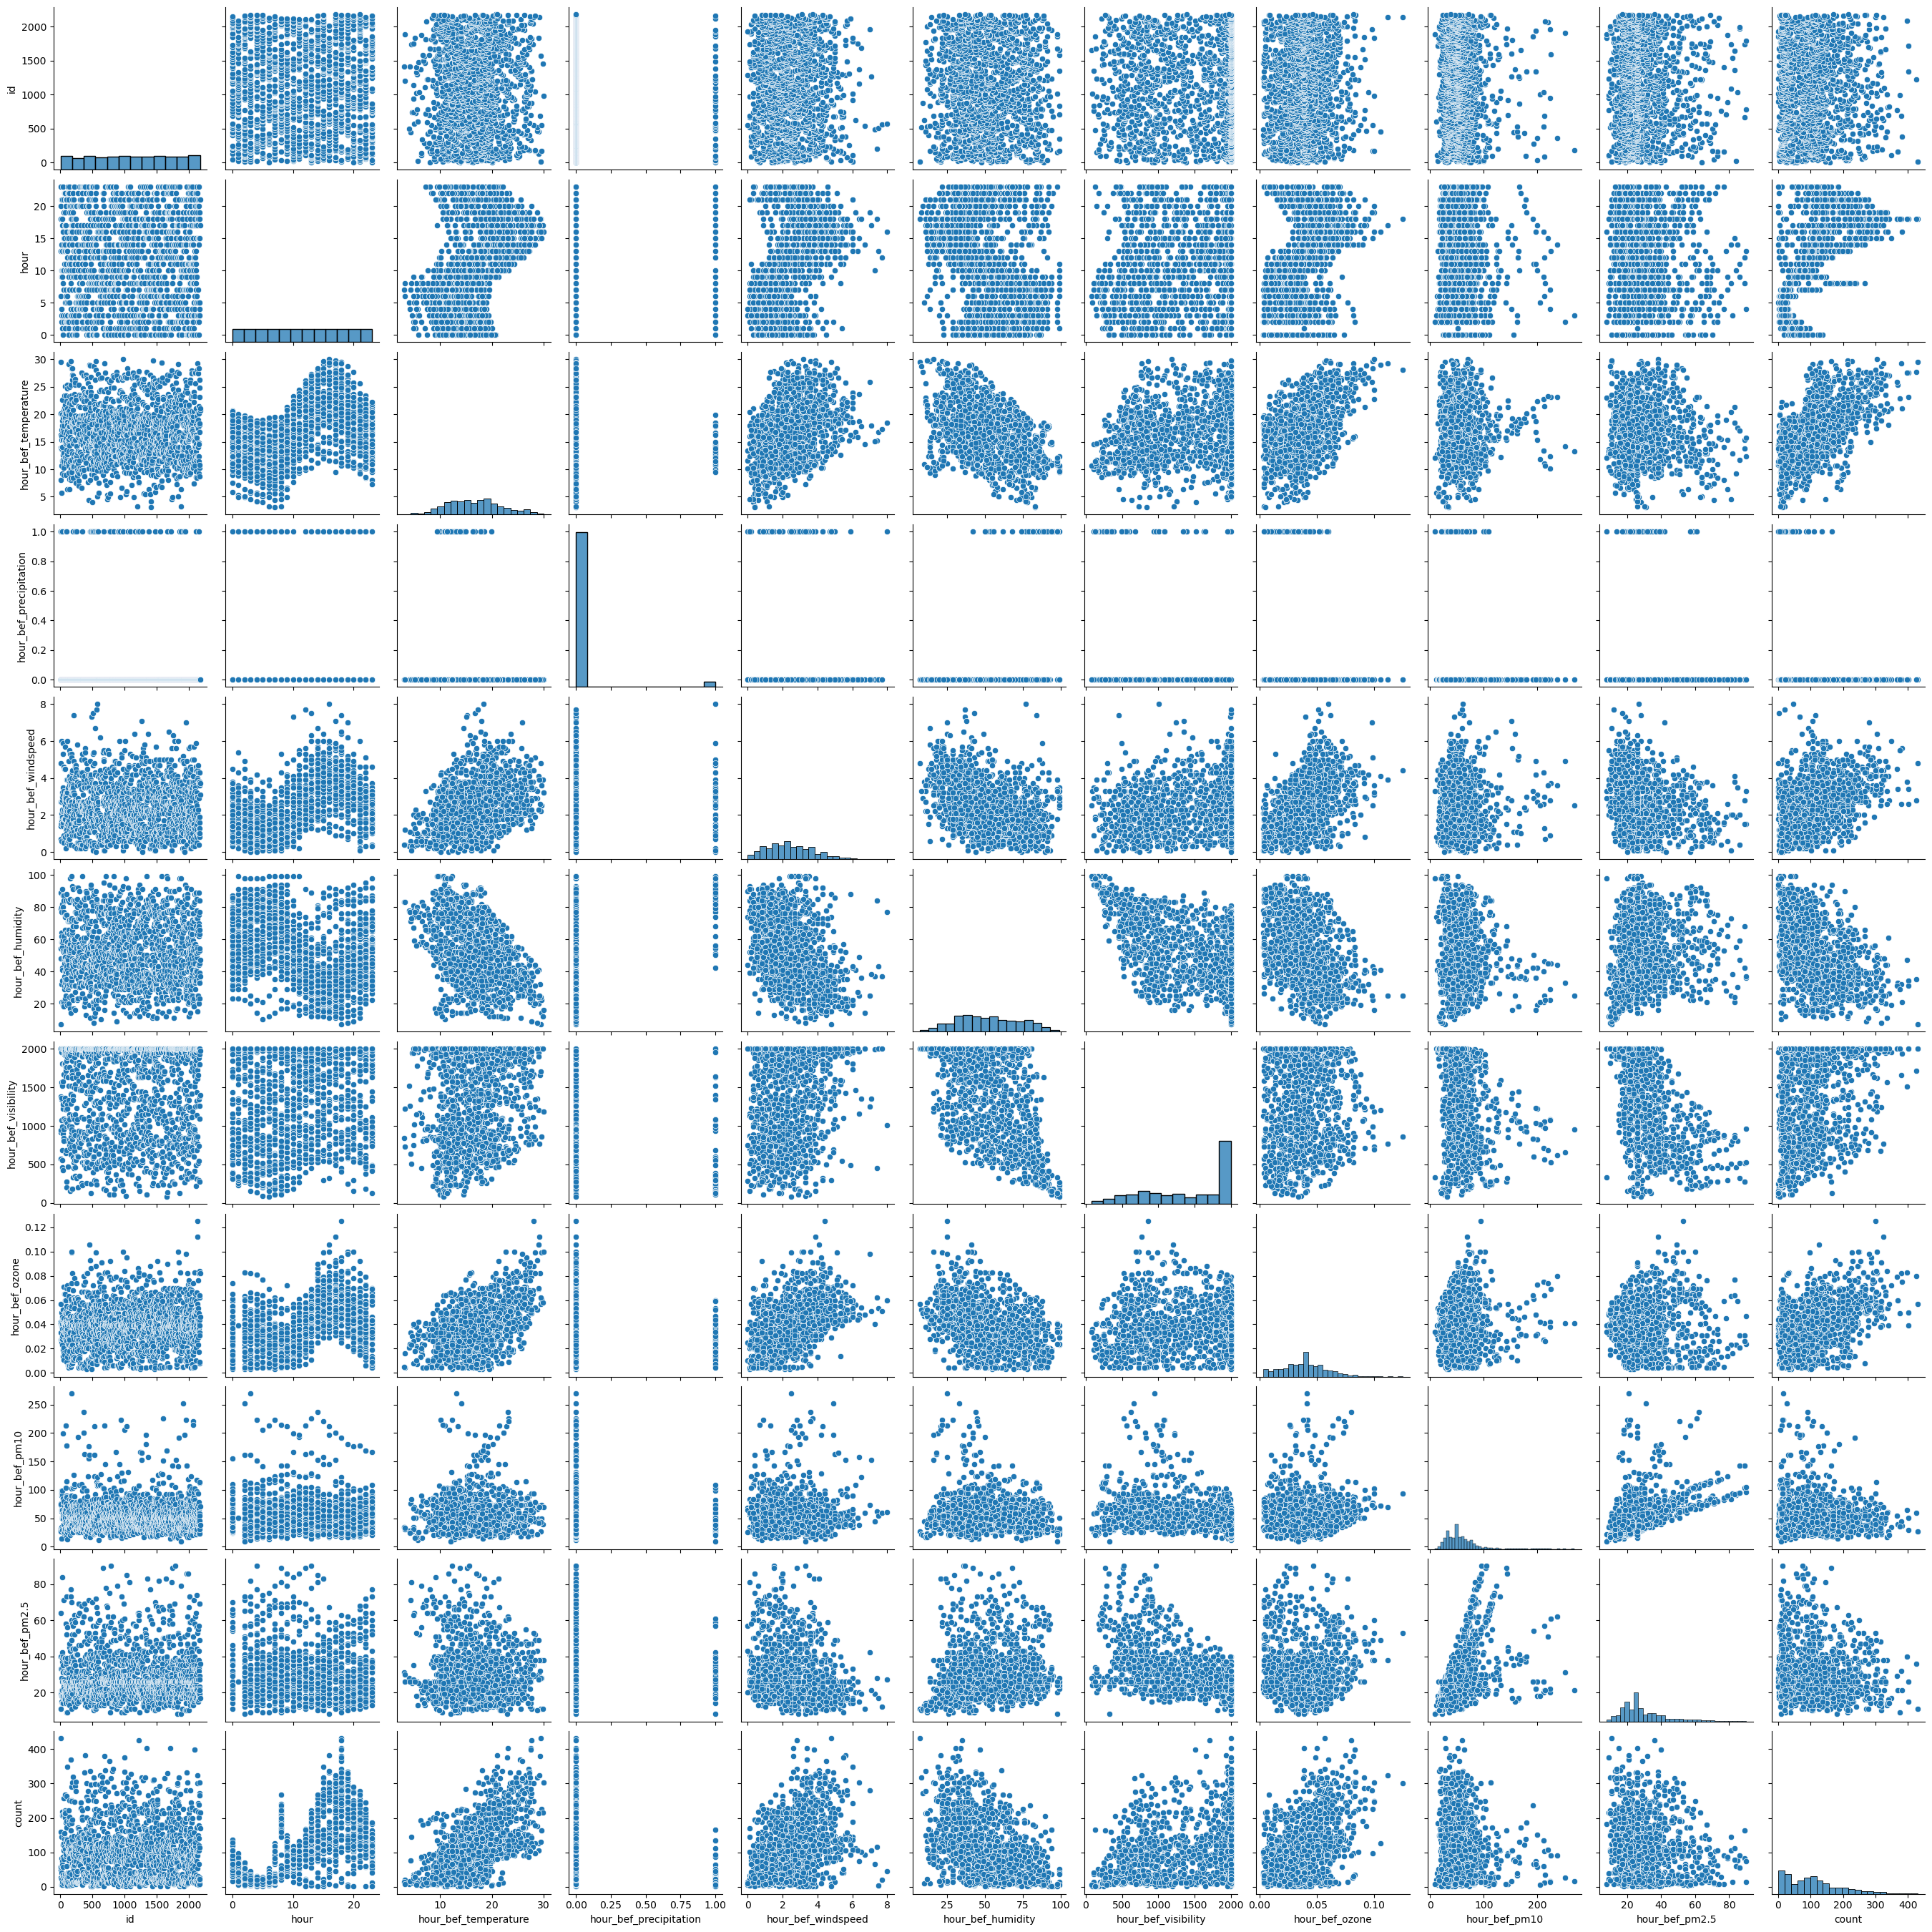

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(train)
plt.show()

### count와 선형관계에 있는 것 떼어서 보기

비가 온지 여부 제외하고 전부 선형관계 확인
- 단,visibility는 max값이 너무 많아서 빼고자 합니다.

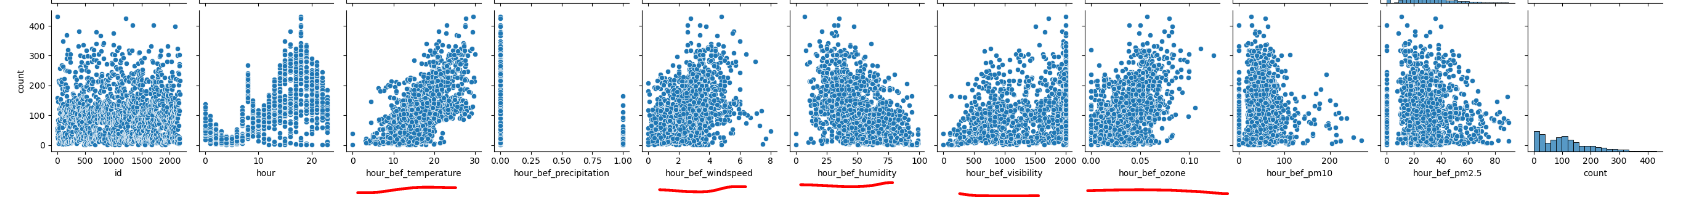

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1457 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      1457 non-null   int64  
 1   hour                    1457 non-null   int64  
 2   hour_bef_temperature    1457 non-null   float64
 3   hour_bef_precipitation  1457 non-null   float64
 4   hour_bef_windspeed      1457 non-null   float64
 5   hour_bef_humidity       1457 non-null   float64
 6   hour_bef_visibility     1457 non-null   float64
 7   hour_bef_ozone          1457 non-null   float64
 8   hour_bef_pm10           1457 non-null   float64
 9   hour_bef_pm2.5          1457 non-null   float64
 10  count                   1457 non-null   float64
dtypes: float64(9), int64(2)
memory usage: 136.6 KB


### 데이터 정규화
#### 해도되고 안해도 되고....이상치가 없다면 굳이?

In [167]:
# id, hour_bef_visibility, hour_bef_precipitation 제거
# id는 굳이..? visibility는 max 2000값이 너무 많아서 precipitation은 0,1로만 구성된 비연속적 데이터

train.drop(axis = 1, columns = ['id', 'hour_bef_visibility', 'hour_bef_precipitation'])

In [168]:
train.head()

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
0,20,16.3,1.5,89.0,0.027,76.0,33.0,49.0
1,13,20.1,1.4,48.0,0.042,73.0,40.0,159.0
2,6,13.9,0.7,79.0,0.033,32.0,19.0,26.0
3,23,8.1,2.7,54.0,0.040,75.0,64.0,57.0
4,18,29.5,4.8,7.0,0.057,27.0,11.0,431.0


In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train.values[:,:-1]).round(4)

train_scaled_df = pd.DataFrame(train_scaled, columns=train.columns[:-1])
train_scaled_df['target'] = train['count']

train = train_scaled_df

train.tail()

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,target
1452,-1.0839,0.0158,-0.6389,0.0377,-0.4285,-0.6423,-0.2108,8.0
1453,-1.2285,-1.1299,0.9617,-0.3551,-0.0074,-0.7396,-0.7756,303.0
1454,-0.9393,0.3022,-0.4206,0.0869,-1.5863,-0.8694,-0.6344,21.0
1455,1.3740,0.7604,0.8889,-0.7480,2.2556,0.4609,0.4246,20.0
1456,0.7956,0.8368,0.4524,-0.2569,0.3610,-0.6099,-0.9168,22.0


In [37]:
# from sklearn.preprocessing import MinMaxScaler #최대 1 최소 0으로 되게끔 

# scaler = MinMaxScaler()
# scaler.fit(train_1.values[:,:-1])
# train_1.values[:,:-1] = scaler.transform(train_1.values[:,:-1]).round(4)

# train_1.tail() 

## id, hour_bef_precipitation 등 필요없는 칼럼 제외

### k-fold로 값 나눠주기

#### StratifedKFold
- 레이블 데이터가 왜곡됬을 경우 반드시.
- 일반적으로 분류에서의 교차 검증
- 비율을 동일하게 나눔

#### kfold
- 회귀문제

##### 사용 파라미터
- n_splits : 분할할 세트의 개수, 1세트만 test 데이터로 사용하고 나머지는 train 데이터로 사용

- shuffle : True로 설정 시 데이터셋 내의 순서를 섞어서 샘플링, False인 경우 순서대로 분할

- random_state : seed 설정, 특정 정수로 지정 시 샘플링 결과 고정 -> 셔플안할거면 고정 안해도 됨

 


- 옵튜나 : https://hojjimin-statistic.tistory.com/27


In [171]:
import numpy as np
from sklearn.model_selection import KFold

x = np.array(train.values[:,-1:])
y = train.values[:,:-1]

# split 개수, 셔플 여부 및 seed 설정
kfold = KFold(n_splits = 5, shuffle = False)

In [172]:
print(kfold)

KFold(n_splits=5, random_state=None, shuffle=False)


## 앙상블, 랜덤포레스트 쓰기

n_estimators : 생성할 tree의 개수와

max_features : 최대 선택할 특성의 수

In [175]:
train.isnull().sum()


hour                    0
hour_bef_temperature    0
hour_bef_windspeed      0
hour_bef_humidity       0
hour_bef_ozone          0
hour_bef_pm10           0
hour_bef_pm2.5          0
target                  2
dtype: int64

In [176]:
train.fillna(train.median(numeric_only = True), inplace = True)

In [184]:
train.isnull().sum()

hour                    0
hour_bef_temperature    0
hour_bef_windspeed      0
hour_bef_humidity       0
hour_bef_ozone          0
hour_bef_pm10           0
hour_bef_pm2.5          0
target                  0
dtype: int64

In [178]:
train.head()

,hour,hour_bef_temperature,hour_bef_windspeed,hour_bef_humidity,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,target
0,1.2294,-0.0797,-0.7116,1.8056,-0.6390,0.6231,0.2128,49.0
1,0.2173,0.6459,-0.7844,-0.2078,0.1504,0.5258,0.7071,159.0
2,-0.7948,-0.5379,-1.2937,1.3146,-0.3232,-0.8045,-0.7756,26.0
3,1.6631,-1.6454,0.1614,0.0869,0.0452,0.5906,2.4015,57.0
4,0.9402,2.4407,1.6892,-2.2212,0.9399,-0.9668,-1.3405,431.0


In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


x = train.values[:,-1:]
y = train['target']

model = RandomForestClassifier(n_estimators = 100)
model.fit(x, y)

RandomForestClassifier()

In [190]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracy_history = []

# K-fold 검증 과정으로 실제 랜덤 포레스트 모델을 학습하여 정확도 평균을 내는 방법
for train_index, test_index in kfold.split(x): # for문으로 index순회하면서 train, test셋 뽑기

    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100) # 모델 선언
    model.fit(X_train, y_train) # 모델 학습

    y_pred = model.predict(X_test) # 예측 라벨
    accuracy_history.append(accuracy_score(y_pred, y_test)) # 정확도 측정 및 기록

print("각 분할의 정확도 기록 :", accuracy_history)
print("평균 정확도 :", np.mean(accuracy_history))

각 분할의 정확도 기록 : [0.928082191780822, 0.9212328767123288, 0.9484536082474226, 0.9415807560137457, 0.9553264604810997]
평균 정확도 : 0.9389351786470839
